<a href="https://colab.research.google.com/github/LDANY/M2-Generatif/blob/main/score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score-Based Generative Modeling through Stochastic Differential Equations (SDE)


Élèves : LIU Luodan, SHEN Pingya, YUAN Haoyue ([texte du lien](https://)Groupe 7)

Enseignants : Sylvain Le Corff


In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
uploaded = files.upload()

Saving ode_3.png to ode_3.png


# Chap1 SMLD et son SDE,son reverse-SDE

## 1.1 Inconvénients des modèles génératifs traditionnels



Les modèles génératifs profonds ont toujours été au cœur de la recherche sur l’apprentissage automatique. L'accent est mis sur la façon de modéliser et d'ajuster des distributions de données complexes. Afin d'atteindre cet objectif, l'industrie a proposé divers modèles génératifs profonds, tels que les (**VAE**)[Variational Autoencoder](https://link.springer.com/chapter/10.1007/978-3-030-70679-1_5), les flux de régularisation [Normalization Flow](https://arxiv.org/abs/1908.09257), les réseaux contradictoires génératifs [GAN](https://arxiv.org/abs/1406.2661), les modèles autorégressifs (**Autoregressive Model**), etc. Chacun de ces modèles présente ses propres avantages et inconvénients.

Par exemple, le plus gros problème de VAE est de savoir comment modéliser la distribution a posteriori cible $q(z|x)$ et la distribution a priori $p(z)$. L'approche traditionnelle consiste à modéliser les deux distributions sous forme de distributions gaussiennes, ce qui est pratique pour échantillonner et calculer la distance entre les distributions antérieure et postérieure (divergence KL). Mais il est évident que le plus gros problème de la VAE est de savoir comment modéliser ces deux distributions : si le plan est trop complexe, il ne sera ni pratique d'échantillonner ni de calculer la divergence KL. Cependant, la sélection est simple mais difficile à représenter une distribution de données complexe. Bien que le flux régularisé permette de calculer la fonction de vraisemblance précise, sa plus grande limitation est que le calcul de chaque étape nécessite une fonction réversible, ce qui limite également la sélection des transformations à chaque étape du flux régularisé, affecte également la capacité globale d’ajustement.

 Les problèmes liés au GAN et aux modèles autorégressifs sont également évidents. Le plus gros problème avec GAN est que la formation est particulièrement instable, difficile à adapter et facile à modéliser. Le plus gros problème rencontré par le modèle autorégressif dans le domaine des images est que la vitesse de génération est trop lente et que l'espace de décodage est trop grand, ce qui rend difficile la génération d'images haute résolution.

Bien que on peut trouver des contre-exemples pour chacun des problèmes ci-dessus, par exemple, le modèle autorégressif peut être combiné avec VAE pour générer des images haute résolution (telles que **VQGAN**), le modèle de diffusion peut être considéré comme un modèle de niveau Markov. VAE (**MHVAE**) et VAE peuvent utiliser la régularisation Modélisation de flux distribution préalable, etc. Cependant, les problèmes ci-dessus existent objectivement et constituent également quelques-uns des principaux problèmes dans le domaine de la recherche.

##1.2 Du modèle énergétique au Score-Matching



Tout d'abord, pour ajuster la distribution des données, la méthode la plus courante est l'estimation du maximum de vraisemblance (**MLE**)

$𝔼_{x∼{p_{data(x)}}}[log(p_Θ(x)]$ : c'est-à-dire que les données échantillonnées à partir de la distribution de données réelle doivent être capables de maximiser la probabilité dans la distribution de données que on modélise.

Généralement, nous modéliserons cette distribution de probabilité comme ceci (**EBM**) :
$$p_\theta(x)=\frac{-E_\theta(\mathbf{x})}{Ζ_\theta} $$

Il peut être appelé modèle probabiliste non normalisé ou modèle basé sur l'énergie.


$Z_\theta$ est la garantie du terme de normalisation
$p_\theta$ est la probabilité.
$θ$ est leur paramètre.
Nous pouvons généralement entraîner les paramètres θ en maximisant la log-vraisemblance.
Mais pour la plupart des fonctions énergétiques, la somme de leurs fonctions normalisées Z est difficile à calculer. Afin de résoudre ce problème, les modèles de vraisemblance traditionnels ont fait divers degrés de compromis.


Par exemple, le modèle autorégressif suppose une convolution dépendante unidirectionnelle, le flux autorégressif nécessite des calculs réversibles, la VAE utilise une approximation variationnelle de la limite inférieure et le calcul approximatif repose également sur des hypothèses fortes sous forme d'a priori, etc.

Mais en fait, peut-on calculer directement le maximum de vraisemblance sans imposer trop de contraintes sur la forme du modèle énergétique ? Il existe deux idées dominantes : l’une consiste à utiliser la méthode MCMC et l’autre à utiliser la méthode Score-matching.


##1.3 Score-Matching


La fonction de score ([Provable benefits of score matching](https://arxiv.org/abs/2306.01993)) est définie comme : $$s_\theta=∇_x logp_θ(x)$$

On peut donc constater que la fonction score n'a rien à voir avec $Z_\theta$ :
$$s_\theta(x)=∇_xlogp_\theta(x)= -∇_x E_θ(x)-∇_x logZ_\theta=-∇_x E_θ(x)$$

Nous voulons maintenant former un réseau pour estimer la fonction de score réel. Naturellement, nous pouvons minimiser la fonction de score réel et le MSE de la sortie réseau :
$$ℒ=𝔼_{p(x)}[||∇_x logp(x)-s_\theta(x)||^2] $$


Mais nous ne pouvons pas calculer une telle perte car nous ne savons pas quel est le véritable $p(x)$. La méthode d’appariement des scores nous permet de minimiser cette perte sans connaître le vrai $p(x)$.

Nous élargissons la valeur attendue de la perte：
$$
\begin{aligned}
\mathcal{L} & =\mathbb{E}_{p(\mathbf{x})}\left[\left\|\nabla_{\mathbf{x}} \log p(\mathbf{x})-\mathbf{s}_\theta(\mathbf{x})\right\|^2\right] \\
& =\int p(\mathbf{x})\left[\left\|\nabla_{\mathbf{x}} \log p(\mathbf{x})\right\|^2+\left\|\mathbf{s}_\theta(\mathbf{x})\right\|^2-2\left(\nabla_{\mathbf{x}} \log p(\mathbf{x})\right)^T \mathbf{s}_\theta(\mathbf{x})\right] d \mathbf{x}
\end{aligned}
$$

Le premier terme est constant pour $\theta$ et peut être ignoré.
Le deuxième élément est
$$
\int p(\mathbf{x})\left\|\mathbf{s}_\theta(\mathbf{x})\right\|^2 d \mathbf{x} .
$$

Pour le troisième terme, si la dimension de $\mathrm{x}$ est $N$ :
$$
\begin{aligned}
& -2 \int p(\mathbf{x})\left(\nabla_{\mathbf{x}} \log p(\mathbf{x})\right)^T \mathbf{s}_\theta(\mathbf{x}) d \mathbf{x} \\
= & -2 \int p(\mathbf{x}) \sum_{i=1}^N \frac{\partial \log p(\mathbf{x})}{\partial \mathbf{x}_i} \mathbf{s}_{\theta i}(\mathbf{x}) d \mathbf{x} \\
= & -2 \sum_{i=1}^N \int p(\mathbf{x}) \frac{1}{p(\mathbf{x})} \frac{\partial p(\mathbf{x})}{\partial \mathbf{x}_i} \mathbf{s}_{\theta i}(\mathbf{x}) d \mathbf{x} \\
= & -2 \sum_{i=1}^N \int \frac{\partial p(\mathbf{x})}{\partial \mathbf{x}_i} \mathbf{s}_{\theta i}(\mathbf{x}) d \mathbf{x} \\
= & 2 \sum_{i=1}^N-\int \frac{\partial p(\mathbf{x}) \mathbf{s}_{\theta i}(\mathbf{x})}{\partial \mathbf{x}_i} d \mathbf{x}+\int p(\mathbf{x}) \frac{\partial \mathbf{s}_{\theta i}(\mathbf{x})}{\partial \mathbf{x}_i} d \mathbf{x} \\
= & 2 \sum_{i=1}^N-\left.\int p(\mathbf{x}) \mathbf{s}_{\theta i}(\mathbf{x})\right|_{-\infty} ^{\infty} d \mathbf{x}_{/ \mathbf{i}}+\int p(\mathbf{x}) \frac{\partial \mathbf{s}_{\theta i}(\mathbf{x})}{\partial \mathbf{x}_i} d \mathbf{x} \\
= & 2 \sum_{i=1}^N \int p(\mathbf{x}) \frac{\partial \mathbf{s}_{\theta i}(\mathbf{x})}{\partial \mathbf{x}_i} d \mathbf{x} \\
= & 2 \int p(\mathbf{x}) \sum_{i=1}^N \frac{\partial \mathbf{s}_{\theta i}(\mathbf{x})}{\partial \mathbf{x}_i} d \mathbf{x} \\
= & 2 \int p(\mathbf{x}) \operatorname{tr}\left(\nabla_{\mathbf{x}} \mathbf{s}_\theta(\mathbf{x})\right) d \mathbf{x}
\end{aligned}
$$

La perte finale est donc la somme des deuxième et troisième termes :
$$
\begin{aligned}
\mathcal{L} & =\int p(\mathbf{x})\left\|\mathbf{s}_\theta(\mathbf{x})\right\|^2 d \mathbf{x}+2 \int p(\mathbf{x}) \operatorname{tr}\left(\nabla_{\mathbf{x}} \mathbf{s}_\theta(\mathbf{x})\right) d \mathbf{x} \\
& =\mathbb{E}_{p(\mathbf{x})}\left[\left\|\mathbf{s}_\theta(\mathbf{x})\right\|^2+2 \operatorname{tr}\left(\nabla_{\mathbf{x}} \mathbf{s}_\theta(\mathbf{x})\right)\right]
\end{aligned}
$$

##1.4 Intro de SMLD




###Langevin Dynamics



Maintenant que nous avons appris la fonction de score de la distribution de données via le réseau neuronal, comment utiliser la fonction de score pour obtenir des échantillons de cette distribution de données ? La réponse est **Langevin Dynamics** :

$$x_{i+1}=x_{i} + ϵ∇_x logp(x) + \sqrt{2ϵ}z_i ,  z_i∼𝒩(0,Ι),  i=0,1,...,K $$

L'échantillonnage ici est un processus itératif.
$ϵ$ est une petite quantité. $x_0$ est initialisé et mis à jour de manière aléatoire via la méthode itérative ci-dessus. Lorsque le nombre d'itérations $K$
est suffisamment grand, $x$ converge vers un échantillon de la distribution.





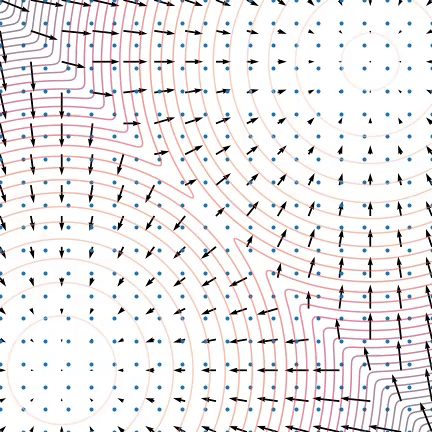

In [ ]:
# @title Mise à jour itérative des points d'échantillonnage

from IPython.display import Image

image_path = 'ezgif-1-0eef44b6bb.gif'
Image(image_path)


### La combinaison

De cette façon, nous obtenons réellement un modèle génératif. Nous pouvons d'abord entraîner un réseau pour estimer la fonction de score, puis utiliser Langevin Dynamics et la fonction de score estimé du réseau pour échantillonner afin d'obtenir des échantillons de la distribution d'origine. Parce que l’ensemble de la méthode consiste en une correspondance de scores et en Langevin Dynamics, elle est appelée SMLD.





###Le piège



Nous avons maintenant le modèle de génération SMLD, mais en fait ce modèle pose de gros problèmes.
$$ℒ=𝔼_{p(x)}[||∇_x logp(x)-s_\theta(x)||^2]= ∫p(x)||∇_x logp(x)-s_θ(x)||^2 dx$$
En observant la fonction de perte que nous avons utilisée pour entraîner le réseau neuronal, nous pouvons constater que ce terme L2 est en réalité pondéré par $p(x)$. Par conséquent, pour les zones à faible probabilité, la fonction de score estimé est très imprécise.

Alors, comment pouvons-nous résoudre le problème ci-dessus ?

En fait, la zone des zones à forte probabilité peut être élargie en ajoutant des perturbations sonores aux données. L'ajout de bruit gaussien à la distribution originale augmentera la variance de la distribution originale. De cette manière, la zone correspondant à la zone à forte probabilité augmente et la fonction de score d'un plus grand nombre de zones peut être estimée avec précision.

Mais comment contrôler l’intensité des nuisances sonores pose problème :

* L'intensité est trop faible pour être efficace et la zone de forte probabilité est encore trop petite.
* L'intensité est trop élevée, cela détruira la distribution originale des données et la fonction de score estimé aura peu de relation avec la distribution originale.





###La solution


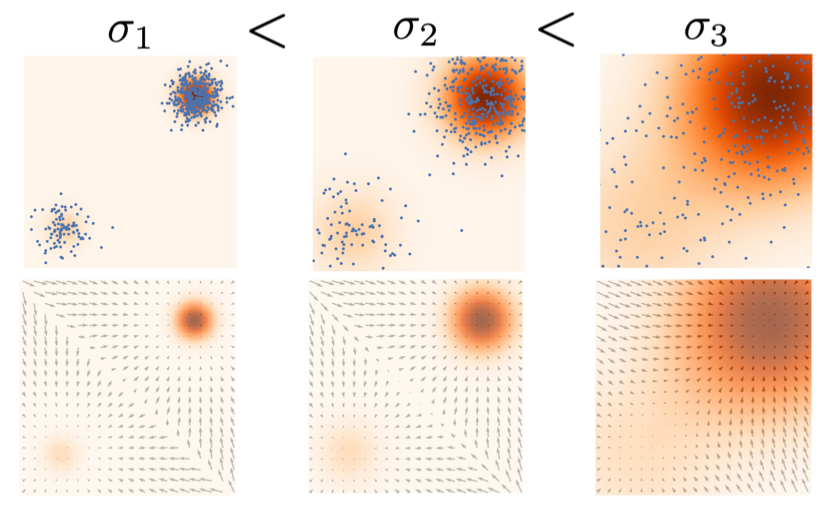

In [ ]:
# @title la distribution originale avec différents bruits

from IPython.display import Image

image_path = '截屏2024-04-07 14.20.35.png'
Image(image_path)



L'ajout de différents niveaux de bruit permet au réseau d'apprendre la fonction de score de la distribution originale avec différents bruits. Nous définissons la séquence ${σ_i,i=1,...,N}, σ_i < σ_2 <...< σ_N$, représente l’intensité du bruit de petite à grande. De cette manière, nous pouvons définir les échantillons de données après perturbation sonore pour obéir à une distribution après perturbation sonore,
$$x+σ_iz ∼ p_{σ_i}(\tilde x) =∫p(x)𝒩(\tilde x;x,σ_i^2Ι)dx$$

Nous utilisons un réseau de neurones pour estimer la fonction score d'une distribution perturbée par le bruit,
$$ℒ=∑_{i=1}^N σ_i^2 𝔼_{p_{σ_i}(x)}[||∇_x logp_{σ_i}(x)-s_\theta(x)||^2]$$

La méthode d'échantillonnage doit également être modifiée en conséquence. Nous faisons un échantillonnage Langevin pour différentes intensités de bruit L, L-1,...,1, et le résultat de l'échelle précédente est utilisé cette fois comme initialisation. Cette méthode d'échantillonnage est également appelée [dynamique de Langevin recuite](https://uvadl2c.github.io/lectures/Advanced%20Generative%20&%20Energy-based%20Models/modern-based-models/lecture%204.2.pdf).



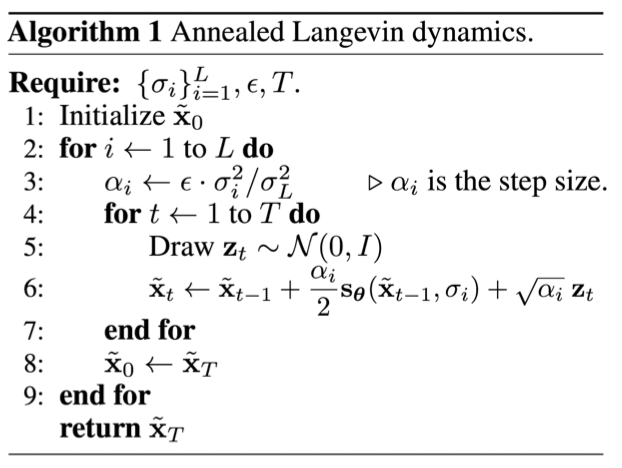

In [ ]:
# @title algorithme

from IPython.display import Image

image_path = '截屏2024-04-07 14.20.49.png'
Image(image_path)


## 1.5 SDE


Nous proposons une équation différentielle stochastique (**SDE**) qui transforme en douceur une distribution de données complexe en une distribution antérieure connue en injectant lentement du bruit, et une SDE en temps inverse correspondante qui transforme la distribution antérieure en une distribution de données en supprimant lentement le bruit.

Lorsque nous appliquons suffisamment de temps itératifs à la dynamique de Langevin, nous pouvons utiliser SDE pour modéliser ce processus d'échantillonnage.



###Intro d'équation différentiel


Lors de l'étude de phénomènes objectifs, nous rencontrons souvent un type de problème mathématique dans lequel la dépendance fonctionnelle entre une certaine variable et d'autres variables est inconnue, mais cette relation fonctionnelle inconnue et ses dérivées (ou différentielles de certains ordres) ainsi que les variables indépendantes sont reliés par une équation connue. Une telle équation est appelée une équation différentielle (**Differential Equation**). En termes simples, une équation différentielle fait référence à une équation contenant une fonction inconnue et ses dérivées.

Cependant, nous devons souvent faire face à certaines fonctions de processus stochastiques, c'est-à-dire des variables aléatoires qui changent avec le temps. À l'heure actuelle, les équations différentielles générales ne sont plus applicables. Lorsqu'il s'agit de processus aléatoires, des méthodes de traitement spéciales sont nécessaires.Parmi tous les processus aléatoires, le **processus de diffusion** est le processus aléatoire le plus fondamental et le plus courant qui est un processus de Markov en temps continu.

Le processus de diffusion peut être décrit par l'équation différentielle spéciale suivante
**$$dX_t=a(X_t,t)dt+b(X_t,t)dW_t$$**

$t$ est le temps continu,$W_t$ est  un mouvement brownien,$a(X_t,t)$ est **drift coefficient**, $b(X_t,t)$ est **diffusion coefficient**.


### Le processus d’ajout de bruit

$$x_{i+1}=x_{i} + ϵ∇_x logp(x) + \sqrt{2ϵ}z_i ,   i=0,1,...,K $$

Quand $K→∞$, on définit $Δt=ϵ, \Delta t→0$,
$$x_{t+Δt}-x_t=∇_x logp(x_i)Δt + \sqrt{2Δt}z_i $$
On remplace les seux termes par les fonctions f=∇_x logp(x_i)et g=\sqrt2:
$$x_{t+Δt}-x_t=f(x,t)Δt + g(t)\sqrt{Δt}z_i  , avec\sqrt{Δt}z_i ∼ 𝒩(0,ΔtΙ) $$

Le mouvement brownien peut être introduit ici. Si nous définissons $w$ comme un mouvement brownien, alors
$$w_{t+Δt}=w_t+𝒩(0,ΔtΙ), \sqrt{Δt}z_i =w_{t+Δt}-w_t$$

Ramenons le mouvement brownien à ce qui précède, et quand $\Delta t→0$, on a **$$dx=f(x,t)dt+g(t)dw$$**

Ici **f(x,t)** est appelé coefficient de dérive(**drift coefficient**) et **g(t)** représente le coefficient de diffusion(**diffusion coefficient**). La solution SDE représente également le processus d’ajout continu de bruit aux données.


### VE SDE


En fait, différents SDE correspondent à différentes manières d’ajouter du bruit. Avec le framework SDE, nous pouvons constater que SMLD peuvent en fait être écrits sous la forme de SDE.

Pour SMLD, la façon d'ajouter du bruit est:
$$
\left\{\begin{array}{l}
\mathbf{x}_i=\mathbf{x}+\sigma_i \mathbf{z} \\
\mathbf{x}_{i-1}=\mathbf{x}+\sigma_{i-1} \mathbf{z}
\end{array}\right.
$$

En soustrayant les deux, on obtient
$$
\begin{gathered}
\mathbf{x}_i-\mathbf{x}_{i-1}=\sigma_i \mathbf{z}-\sigma_{i-1} \mathbf{z} \\
\mathbf{x}_i=\mathbf{x}_{i-1}+\sqrt{\sigma_i^2-\sigma_{i-1}^2} \mathbf{z}
\end{gathered}
$$

quand $K \rightarrow \infty$ ,
$$
\begin{aligned}
& \mathbf{x}(t+\Delta t)=\mathbf{x}(t)+\sqrt{\sigma^2(t+\Delta t)-\sigma^2(t)} \mathbf{z}(t) \\
& \approx \mathbf{x}(t)+\sqrt{\frac{\mathrm{d} \sigma^2(t)}{\mathrm{d} t} \Delta t} \mathbf{z}(t) \\
&= \mathbf{x}(t)+\sqrt{\frac{\mathrm{d} \sigma^2(t)}{\mathrm{d} t}} \sqrt{\Delta t} \mathbf{z}(t) \\
& \mathbf{x}(t+\Delta t)-\mathbf{x}(t)=\sqrt{\frac{\mathrm{d} \sigma^2(t)}{\mathrm{d} t}} \sqrt{\Delta t} \mathbf{z}(t) \\
& \mathrm{d} \mathbf{x}=\sqrt{\frac{\mathrm{d} \sigma^2(t)}{\mathrm{d} t}} \mathrm{~d} \mathbf{w}
\end{aligned}
$$

Il s'appelle Variance Exploding SDE (**VE SDE**).

## 1.6 reverse SDE



>Le processus de génération d'échantillons est la solution du SDE inverse.

"Reverse SDE" fait référence à l'équation différentielle stochastique inverse, qui est un processus qui transforme en douceur une simple distribution de bruit en une distribution de données complexe. La définition du SDE inversé dépend du temps car elle est dérivée du score de densité de probabilité marginale des données en fonction du temps. En inversant ce processus, nous pouvons progressivement transformer le bruit aléatoire en données pour la génération d’échantillons. Après avoir entraîné un réseau neuronal dépendant du temps pour estimer les scores, nous pouvons exploiter un solveur numérique SDE pour générer des échantillons. .



*   Méthodes de calcul numérique traditionnelles
 1. Euler–Maruyama method:[The truncated Euler–Maruyama method for stochastic differential equations](https://www.sciencedirect.com/science/article/pii/S0377042715003210)
 2. Stochastic Runge–Kutta method:[Runge–Kutta methods for numerical solution of stochastic differential equations](https://www.sciencedirect.com/science/article/pii/S0377042701003806)

*   Échantillonneurs prédicteurs-correcteurs (**Predictor-Corrector samplers**)

 1. la phase de prédiction : Au stade de la prédiction, les échantillons candidats sont rapidement générés par un modèle de prédiction ou une méthode d'approximation. Ces échantillons candidats peuvent ne pas obéir à la distribution a posteriori cible, mais peuvent être générés rapidement en peu de temps.

 2. la phase de correction : Au cours de l'étape de correction, ces échantillons candidats sont progressivement corrigés à travers une série d'étapes de correction pour les rapprocher de la distribution a posteriori cible. De cette manière, grâce au processus itératif de prédiction et de correction, des échantillons peuvent finalement être extraits de la distribution a posteriori cible.

 >La méthode prédicteur-correcteur est une méthode d'échantillonnage qui combine un solveur numérique SDE avec des méthodes MCMC basées sur des scores telles que Langevin MCMC et HMC. Il améliore l'efficacité et la stabilité de l'échantillonnage en prédisant le gradient de la distribution à chaque pas de temps et en apportant des corrections à la prédiction.

# Chap 2 DDPM et son SDE, son reverse-SDE


## 2.1 Connexion avec SMLD
Après avoir introduit SMLD, examinons un autre modèle génératif basé sur les processus de diffusion, le modèle de diffusion débruitante probabiliste (DDPM). Comme le SMLD, le DDPM utilise également des équations différentielles stochastiques (SDE) pour simuler le processus de diffusion des données du structuré vers le désordonné, ainsi que son processus inverse. Ces deux méthodes génèrent de nouveaux échantillons de données en simulant les processus de diffusion et de diffusion inverse.

Cependant, bien qu'ils partagent ce cadre basé sur les SDE à un niveau élevé, le SMLD et le DDPM diffèrent considérablement dans les détails de mise en œuvre et la conception de la fonction objectif. Le SMLD se concentre sur l'utilisation de la dynamique de Langevin pour simuler directement le processus de diffusion des données, en se basant sur l'appariement des scores pour entraîner le modèle à estimer les gradients des données. En revanche, le DDPM adopte une approche en plusieurs étapes, qui comprend des phases d'injection de bruit explicites et un processus inverse complexe, ce dernier générant des échantillons en réduisant progressivement le bruit et en restaurant graduellement les données. Cette méthode améliore non seulement la qualité des échantillons générés, mais augmente également la stabilité et la contrôlabilité du modèle dans des applications pratiques.

## 2.2 Principe de fonctionnement

Le DDPM est un modèle génératif basé sur [les processus de diffusion](https://blog.csdn.net/lvoutongyi/article/details/129114098), dont le principe repose sur un concept appelé "processus de diffusion". Ce processus peut être envisagé comme l'ajout progressif de bruit sur une image ou tout autre ensemble de données, jusqu'à ce que les données deviennent complètement aléatoires. Ce processus d'ajout progressif de bruit est appelé "processus direct", il est entièrement prévisible et contrôlable.

Inversement, il y a le "processus inverse", que le DDPM utilise pour générer des données. Dans ce processus inverse, le modèle commence avec du bruit pur et retire progressivement ce bruit, tentant de revenir à l'état original des données. Ce processus est comparable à celui d'une image très floue qui devient progressivement claire, jusqu'à être aussi nette que l'image originale. De cette manière, le DDPM peut générer des échantillons de données complexes à partir de bruit de base, tels que des images claires, des audios cohérents, etc.

Les processus de bruitage et de débruitage du DDPM sont réalisés via deux chaînes de Markov. La chaîne de bruitage transforme les données originales en données de bruit facile à manipuler, généralement modélisées par une distribution normale, tandis que la chaîne de débruitage transforme les données de bruit échantillonnées en nouvelles données générées.


## 2.3 VP SDE


[Le processus direct (ajout de bruit)](https://zhuanlan.zhihu.com/p/565901160) peut être expliqué comme suit : $\mathbf{x}_0 $ est l'image originale, et le processus $\mathbf{x}_{t-1} \rightarrow \mathbf{x}_t$ représente une augmentation progressive du bruit. Entre deux variables adjacentes, il existe une relation linéaire que nous pouvons modéliser par :
$$
\mathbf{x}_t = a_t\mathbf{x}_{t-1} + b_t \mathbf{\varepsilon}_t, \quad \mathbf{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \tag{1}
$$
Nous allons d'abord examiner ces deux coefficients. Comme $\mathbf{x}_{t-1}$ contient plus d'informations, $a_t$ est un coefficient de décroissance, dont la valeur doit satisfaire $0 < a_t < 1$; de même, le coefficient de bruit répond aussi à $0 < b_t < 1$.

En déroulant continuellement l'équation avec $\mathbf{x}_{t-1} = a_{t-1}\mathbf{x}_{t-2} + b_{t-1} \mathbf{\varepsilon}_{t-1}$, nous obtenons :
$$
\begin{aligned}
\mathbf{x}_t &= a_{t}\mathbf{x}_{t-1} + b_t \mathbf{\varepsilon}_{t}\\
&= a_{t}(a_{t-1}\mathbf{x}_{t-2} + b_{t-1} \mathbf{\varepsilon}_{t-1}) + b_t \mathbf{\varepsilon}_{t}\\
&= a_{t}a_{t-1}\mathbf{x}_{t-2} + a_{t} b_{t-1} \mathbf{\varepsilon}_{t-1} + b_t \mathbf{\varepsilon}_{t}\\
&= \dots\\
&= (a_{t}\dots a_1) \mathbf{x}_{0} + (a_{t}\dots a_2)b_1\mathbf{\varepsilon}_{1} + (a_{t}\dots a_3)b_2\mathbf{\varepsilon}_{2} + \dots + a_{t} b_{t-1} \mathbf{\varepsilon}_{t-1} + b_t \mathbf{\varepsilon}_{t}
\end{aligned} \tag{2}
$$

Mis à part le premier terme, les termes suivants sont une somme de bruits gaussiens indépendants, et leur somme est également une distribution normale avec une moyenne de 0 et une variance égale à la somme des carrés des coefficients $(a_{t}\dots a_2)^2b_1^2 + (a_{t}\dots a_3)^2b_2^2 + \dots + a_{t}^2 b_{t-1}^2 + b_t^2$.

Cette équation originale peut donc être écrite comme suit :

$$
\mathbf{x}_t = (a_{t}\dots a_1) \mathbf{x}_{0} + \sqrt{(a_{t}\dots a_2)^2b_1^2 + (a_{t}\dots a_3)^2b_2^2 + \dots + a_{t}^2 b_{t-1}^2 + b_t^2} \bar{\mathbf{\varepsilon}}_t, \quad \bar{\mathbf{\varepsilon}}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\tag{3}
$$

Il y a un détail supplémentaire, si nous additionnons les carrés des coefficients, nous pouvons simplifier considérablement cette équation si nous imposons une contrainte telle que $a_t^2 + b_t^2 = 1$, rendant ainsi la somme des carrés égale à 1. En même temps, si nous définissons $\bar{a}_t = (a_{t}\dots a_1)^2$, la partie de variance de l'équation (3) peut être exprimée comme $1 - \bar{a}_t$. Ainsi, nous pouvons récrire l'équation (3) comme :

$$
\mathbf{x}_t = \sqrt{\bar{a}_t} \mathbf{x}_0 + \sqrt{1 - \bar{a}_t} \bar{\mathbf{\varepsilon}}_t, \quad \bar{\mathbf{\varepsilon}}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\tag{5}
$$

Cela simplifie grandement l'approche. À ce stade, nous pouvons réécrire l'équation (1) en remplaçant $a_t$ par $\sqrt{\alpha_t}$ et $b_t$ par $\sqrt{1 - \alpha_t}$, ce qui est conforme à l'article original.

$$
\mathbf{x}_t = \sqrt{\alpha_t} \mathbf{x}_{t-1} + \sqrt{1 - \alpha_t} \mathbf{\varepsilon}_t, \quad \mathbf{\varepsilon}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\tag{6}
$$

Cela explique pourquoi les coefficients sont définis de cette manière (la somme des carrés égale à 1). De plus, il est à noter que $\mathbf{x}_T$ est considéré comme une distribution normale standard, donc le coefficient $a_T$ est proche de 0, et le terme suivant devrait être conçu pour correspondre à $1 - a_t$. Certains auteurs mentionnent que cette conception garantit que la variance reste à une échelle uniforme. Ce processus linéaire peut également être considéré comme un échantillonnage d'une distribution gaussienne, mis en œuvre à l'aide d'une technique de reparamétrisation. Nous pouvons exprimer le processus de transition direct complet comme suit :

$$
\mathbf{x}_t \sim q\left(\mathbf{x}_t | \mathbf{x}_{t-1}\right) = \mathcal{N}\left(\mathbf{x}_t ; \sqrt{\alpha_t} \mathbf{x}_{t-1}, (1 - \alpha_t) \mathbf{I}\right)\tag{7}
$$

Il est important de noter que $\alpha_t$ n'est pas un paramètre appris, mais est lié à $\beta_t$ dans l'article original par la relation $\alpha_t = 1 - \beta_t$. Nous pouvons également exprimer l'équation (5) en termes de probabilité, où $a$ est également remplacé par $\alpha$.
$$
\begin{align*} x(t+\Delta t) &= \sqrt{1 - \beta(t+\Delta t)\Delta t}\; \mathbf{x}(t) + \sqrt{\beta(t+\Delta t)\Delta t}\; \mathbf{\varepsilon}(t)\\ &\approx \mathbf{x}(t) - \frac{1}{2} \beta(t+\Delta t)\mathbf{x}(t)\Delta t + \sqrt{\beta(t+\Delta t)\Delta t}\; \mathbf{\varepsilon}(t)\\ &\approx \mathbf{x}(t) - \frac{1}{2} \beta(t)\mathbf{x}(t)\Delta t + \sqrt{\beta(t)\Delta t}\; \mathbf{\varepsilon}(t)\tag{8} \end{align*} $$

$$
\begin{gather*} \mathbf{x}(t+\Delta t) - \mathbf{x}(t) = - \frac{1}{2} \beta(t)\mathbf{x}(t)\Delta t + \sqrt{\beta(t)\Delta t}\; \mathbf{\varepsilon}(t)\\ \text{d}\mathbf{x} = - \frac{1}{2} \beta(t)\mathbf{x}\text{d}t + \sqrt{\beta(t)}\; \text{d}\mathbf{w}\tag{9} \end{gather*}$$
C'est [Variance Preserving SDE (VP SDE)](https://zhuanlan.zhihu.com/p/583666759).

**Algorithme**
Répéter les étapes suivantes jusqu'à convergence :
   - Échantillonner $ x_0 $ à partir de la distribution initiale des données $ q(x_0) $.
   - Sélectionner aléatoirement un pas de temps $ t $ à partir de la distribution des temps.
   - Échantillonner le bruit $ \epsilon $ à partir d'une distribution normale standard $ N(0, I) $.
   - Réaliser la descente de gradient sur les paramètres $ \theta $ pour minimiser l'erreur de reconstruction $ \|\epsilon - \epsilon_\theta(\sqrt{\alpha_t}x_0 + \sqrt{1-\alpha_t}\epsilon, t)\|^2 $, où $ \epsilon_\theta $ est l'estimation du bruit par le réseau neuronal.

## 2.4 Reverse SDE
L'algorithme que nous connaissons pour les modèles génératifs VAE, où le processus d'encodage et de décodage (génération) est effectué en une seule étape :

$$
\text{Encodage : } x \rightarrow z, \quad \text{Décodage : } z \rightarrow x
$$

Implique trois distributions : le modèle encodeur $ q(z|x) $, le modèle décodeur $ p(x|z) $, et la distribution a priori $ q(z) $. Cette forme simple limite également l'efficacité de la génération. Les modèles de diffusion peuvent être considérés comme un Autoencodeur Variationnel Hiérarchique (HVAE), c'est-à-dire que le processus d'encodage et de décodage est divisé en $ T $ étapes :

$$
\text{Encodage : } x_0 \rightarrow x_1 \rightarrow x_2 \rightarrow \dots \rightarrow x_T \\
\text{Décodage : } x_T \rightarrow x_{T-1} \rightarrow x_{T-2} \rightarrow \dots \rightarrow x_0 \\
$$

La relation entre les distributions est similaire, mais chaque étape est caractérisée par $ q(x_t|x_{t-1}) $ et $ p(x_{t-1}|x_t) $, ce qui est avantageux comme l'utilisation de fonctions linéaires par morceaux pour approximer une courbe, améliorant ainsi l'efficacité de la génération.

Selon la théorie VAE, cette catégorie de modèles génératifs appartient aux modèles basés sur la vraisemblance, donc l'objectif d'optimisation est de maximiser l'estimation de la vraisemblance de la distribution réelle des données $ p_\theta(\boldsymbol{x}_0) $, où $ \theta $ représente les paramètres appris par un réseau de neurones.

Dans le processus inverse, c'est-à-dire le processus de récupération progressive des données originales à partir de données bruitées, il est réalisé grâce à la distribution de probabilité apprise $ p_{\theta}(x_{t-1}|x_t) $. Ce processus peut être considéré comme un processus gaussien conditionnel, exprimé spécifiquement comme :

$$
p_{\theta}(x_{t-1}|x_{t})=\mathcal{N}(x_{t-1}; \mu_{\theta}(x_{t}, t), \Sigma_{\theta}(x_{t}, t))
$$

Ici, $ \theta $ est le paramètre appris par le réseau. La probabilité jointe du processus est :

$$
p_\theta(x_{0:T}) = p(x_T)\prod_{t=1}^T p_\theta(x_{t-1}|x_t)
$$

En maximisant le logarithme de cette distribution jointe, nous pouvons entraîner le modèle à reconstruire les données de manière inverse :

$$
\begin{aligned}
\log p_\theta(x_0) &= \log \int p_\theta(x_{0:T}) \, dx_{1:T} \\
&= \log \int p_\theta(x_{0:T}) \frac{q(x_{1:T} | x_0)}{q(x_{1:T} | x_0)} \, dx_{1:T} \\
&= \log \mathbb{E}_{q(x_{1:T} | x_0)}\left[\frac{p_\theta(x_{0:T})}{q(x_{1:T} | x_0)}\right] \\
&\geq \mathbb{E}_{q(x_{1:T} | x_0)}\left[\log \frac{p_\theta(x_{0:T})}{q(x_{1:T} | x_0)}\right] \\
&= \mathbb{E}_{q(x_{1:T} | x_0)}\left[\log \frac{p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t)}{\prod_{t=1}^T q(x_t | x_{t-1})}\right] \\
&= \mathbb{E}_{q(x_1 | x_0)}\left[\log p_\theta(x_0 | x_1)\right] + \mathbb{E}_{q(x_{T-1}, x_T | x_0)}\left[\log \frac{p(x_T)}{q(x_T | x_{T-1})}\right] + \sum_{t=1}^{T-1} \mathbb{E}_{q(x_{t-1}, x_{t}, x_{t+1} | x_0)}\left[\log \frac{p_\theta(x_t | x_{t+1})}{q(x_t | x_{t-1})}\right]
\end{aligned}
$$

Cette formulation est très importante car elle illustre comment optimiser le modèle en minimisant la divergence KL réelle entre le bruit ajouté de $x_{t-1}$ à $x_t$ et le bruit estimé de $x_{t+1}$ à $x_t$. De plus, elle souligne la nécessité pour le réseau neuronal d'apprendre à reconstruire les données originales $x_0$ à partir de données bruitées à n'importe quelle étape $t$, ce qui est réalisé en minimisant la fonction objectif où le réseau apprend directement le bruit $ \varepsilon_t $ correspondant aux données originales $x_0$ en fonction des changements de $x_t$ et du pas de temps $t$.

Finalement, en maximisant le logarithme de cette distribution jointe, nous pouvons entraîner le modèle à reconstruire les données de manière inverse, atteignant ainsi le but de débruitage. Cette méthode améliore non seulement la qualité des données générées, mais élargit également la capacité du modèle à traiter des données complexes. De cette manière, les modèles de diffusion comme DDPM montrent des performances exceptionnelles dans la génération de données complexes telles que des images et des audios, offrant une alternative plus stable et efficace aux VAE et GANs traditionnels.

**Algorithme**
1. Initialiser $ x_T $ avec un bruit aléatoire provenant de la distribution normale $ N(0, I) $.
2. Pour chaque pas de temps $ t $ de $ T $ à $ 1 $ (en arrière) :
   - Si $ t $ est supérieur à $ 1 $, échantillonner le bruit $ z $ d'une distribution normale standard, sinon $ z $ est nul (car à $ t = 1 $, nous approchons la vraie distribution des données, et le bruit doit être minimisé).
   - Calculer $ x_{t-1} $ comme l'estimation des données pour le pas de temps suivant, en utilisant l'estimation du bruit fournie par le réseau neuronal $ \epsilon_\theta(x_t, t) $ et le $ x_t $ échantillonné lors de l'étape précédente.
   - La formule clé utilisée est $ x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\alpha_t}}\epsilon_\theta(x_t, t)) + \sigma_tz $, qui combine une estimation de débruitage et un peu de bruit supplémentaire pour garantir que le processus d'échantillonnage reste aléatoire.
3. Après $ T $ étapes d'itération, retourner $ x_0 $ comme échantillon de données généré.

#Chap 3 Flux de probabilité et connexion aux ODE neuronaux

---

Référence:
Yang Song (2021). Generative Modeling by Estimating Gradients of the Data Distribution https://yang-song.net/blog/2021/score/

---


##3.1 Introduction

Le Probability flow ODE est un outil influent en modélisation générative basée sur les scores. À l'opposé des échantillonneurs qui utilisent MCMC de Langevin ou des solveurs de SDE, le Probability flow ODE autorise le calcul exact de la vraisemblance log-négative. Ceci est atteint en transformant les SDE en ODE sans modifier leurs distributions marginales. Par la résolution de cette ODE, nous pouvons échantillonner des distributions identiques à celles de la SDE inverse. Ces transformations créent des trajectoires plus lisses tout en préservant les mêmes ensembles de distributions marginales. De plus, le Probability flow ODE hérite des propriétés des ODEs neuronaux, y compris le calcul exact de la vraisemblance log-négative, offrant ainsi un avantage notable pour une modélisation générative réversible et contrôlée.

## 3.2 Formulation mathématique et fondements théoriques

La vraisemblance de la distribution de ce modèle peut être calculée avec précision en exploitant toute la formulation. En transformant une SDE en une ODE sans modifier la distribution marginale $ p_t $, il devient possible d'échantillonner à partir de la même distribution de données en résolvant une ODE au lieu d'une SDE. Les ODE et les SDE transforment tous deux la distribution des données en une distribution antérieure et, en inversant l'ODE, nous pouvons obtenir des échantillons de qualité supérieure à partir de l'antérieur, tout comme en inversant la SDE.

Le Probability flow ODE repose sur la reformulation des SDEs en ODEs. La dynamique stochastique est exprimée par une équation différentielle qui conserve les distributions marginales. Cette équation, définie par :
$$
dx = \left[f(x, t) - \frac{1}{2}g^2(t)\nabla_x \log p_t(x) \right] dt,
$$

où $ f(x, t) $ dans l'ODE le terme de dérive, guide l'évolution de l'état du système, tandis que $ \nabla_x \log p_t(x) $ est le gradient de la log-vraisemblance, reflétant la force et la direction de la 'poussée' stochastique à chaque instant $ t $ et $ \frac{1}{2}g^2(t)\nabla_x \log p_t(x)$ ajuste la trajectoire pour adhérer fidèlement aux distributions marginales.

Cette équation du Probability flow ODE représente un flux déterministe équivalent à la diffusion stochastique d'un SDE, permettant un échantillonnage précis et le calcul exact de la vraisemblance grâce à l'estimation de la fonction de score. Cette structure garantit que, bien que déterministe, l'évolution de l'état du système reste statistiquement cohérente avec le modèle stochastique sous-jacent des SDEs. Ainsi, elle établit un pont entre les processus stochastiques et les systèmes dynamiques contrôlés, optimisant la génération de données et le calcul précis de la vraisemblance.

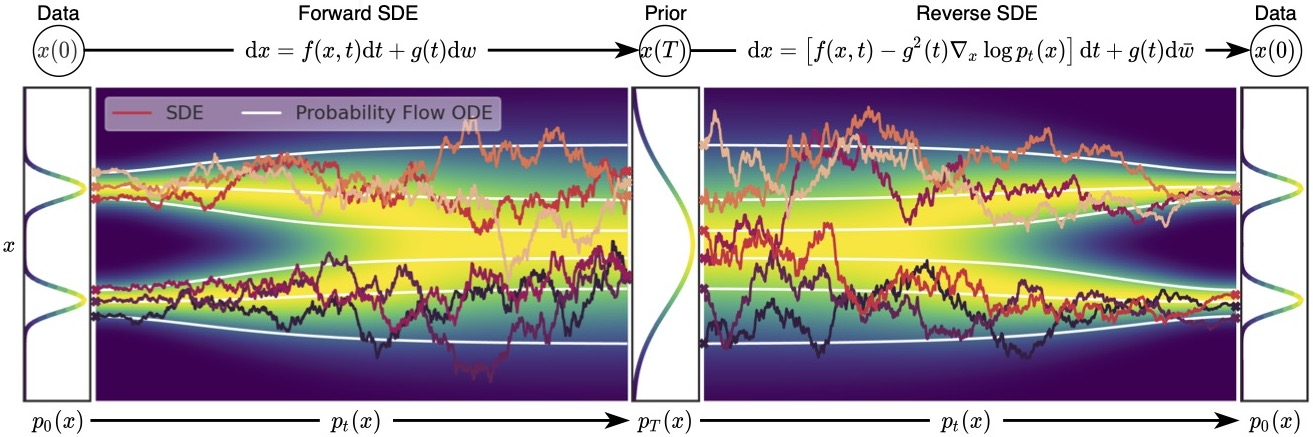

In [ ]:
# @title Les trajectoires
Image('ode_1.png', width=900)

Les illustrations montrent les trajectoires générées par le Forward SDE et le Reverse SDE, ainsi que celles correspondant au Probability flow ODE. On observe que les trajectoires ODE sont plus lisses que celles des SDEs, tout en convertissant la distribution des données en une distribution prior et inversement. Cela confirme que le Probability flow ODE peut cartographier les données vers une distribution de bruit (prior) via un SDE et effectuer une inversion pour la modélisation générative. La même opération est possible avec l'ODE associé, qui offre un processus déterministe échantillonnant de la même distribution que le SDE. L'estimation des fonctions de score permet d'obtenir à la fois le SDE inverse et le Probability flow ODE.


## 3.3 Connexion avec les ODEs neuronaux

Les ODEs Neuronaux modélisent des systèmes dynamiques complexes via des fonctions de dérive paramétrées par des réseaux de neurones, permettant l'apprentissage automatique d'interactions non-linéaires. Les Flux de Normalisation Continus, en tant que transformations réversibles, simplifient une distribution complexe en une distribution normale via des transformations continues, garantissant la réversibilité et la conservation des distributions marginales. La fonction de score, essentielle dans le Probability flow ODE, ajuste la trajectoire de l'ODE pour qu'elle corresponde aux distributions des SDEs, facilitant ainsi un échantillonnage précis et le calcul de la vraisemblance exacte. Cette synergie entre les ODEs neuronaux et le Probability flow ODE offre une plateforme robuste pour la modélisation générative, avec des avantages significatifs en termes de réversibilité, de calcul de la vraisemblance et d'efficacité de la génération de données.


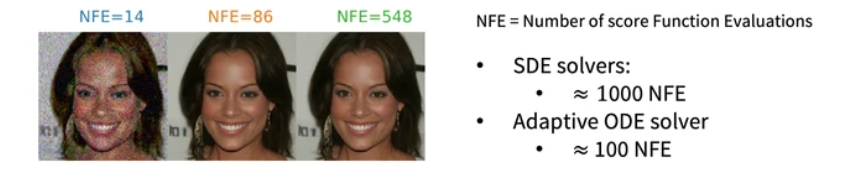

In [ ]:
# @title Les solveurs ODE adaptatifs efficaces pour l'échantillonnage
Image('ode_2.png')

Le Probability flow ODE est une instance spécifique de l'ODE neural, ce qui illustre l'usage d'un réseau neuronal pour le modèle basé sur le score. Cette connexion offre deux avantages significatifs pour la modélisation générative : premièrement, elle permet l'intégration du Probability flow ODE avec des solveurs ODE adaptatifs pour un échantillonnage efficient, réduisant considérablement les calculs par rapport aux solveurs SDE. Par exemple, la génération d'échantillons dans l'image requiert environ 100 évaluations de fonctions avec des solveurs ODE contre 1000 avec des solveurs SDE, ce qui représente une réduction de 90% du calcul. Plus important encore, nous pouvons calculer avec exactitude la vraisemblance de tout échantillon donné grâce à la formule de changement de variables instantanée des ODEs. Cela relie l'identité et la densité prior par une intégrale unidimensionnelle, résolvable précisément avec des méthodes numériques.

**L'algorithme d'échantillonnage ODE**  

L'algorithme est structuré pour générer des données synthétiques à partir d'un modèle de diffusion inverse conditionné par un signal de contrôle. Il initialise les échantillons à partir d'une distribution bruitée et les fait évoluer à travers un processus dynamique inversé jusqu'à atteindre une distribution de données fidèle à la réalité. La forme des échantillons est spécifiée pour correspondre aux dimensions des données réelles, par exemple des images de 32x32 pixels avec trois canaux de couleur pour les images RGB. Les échantillons sont générés par une fonction qui intègre le score de SDE, une échelle inversée des données, et un paramètre de débruitage. La procédure est optimisée pour réduire le nombre d'évaluations de la fonction de score, augmentant ainsi l'efficacité computationnelle. Après la génération, les échantillons sont visualisés pour évaluer la qualité et l'exactitude des images générées par rapport aux données d'entraînement.

## 3.4 Avantages et applications

Le Probability flow ODE présente des avantages uniques pour la modélisation générative, notamment la capacité à générer des échantillons de haute qualité et à calculer avec précision la vraisemblance des modèles. Ce système permet d'effectuer des transformations réversibles, garantissant que les échantillons générés maintiennent une fidélité statistique parfaite avec la distribution originale. Cette précision rend le Probability flow ODE particulièrement adapté pour les applications nécessitant une estimation exacte des densités de probabilité, comme dans les domaines de la bioinformatique et de la finance quantitative.

## 3.5 Résultats expérimentaux et performance du modèle

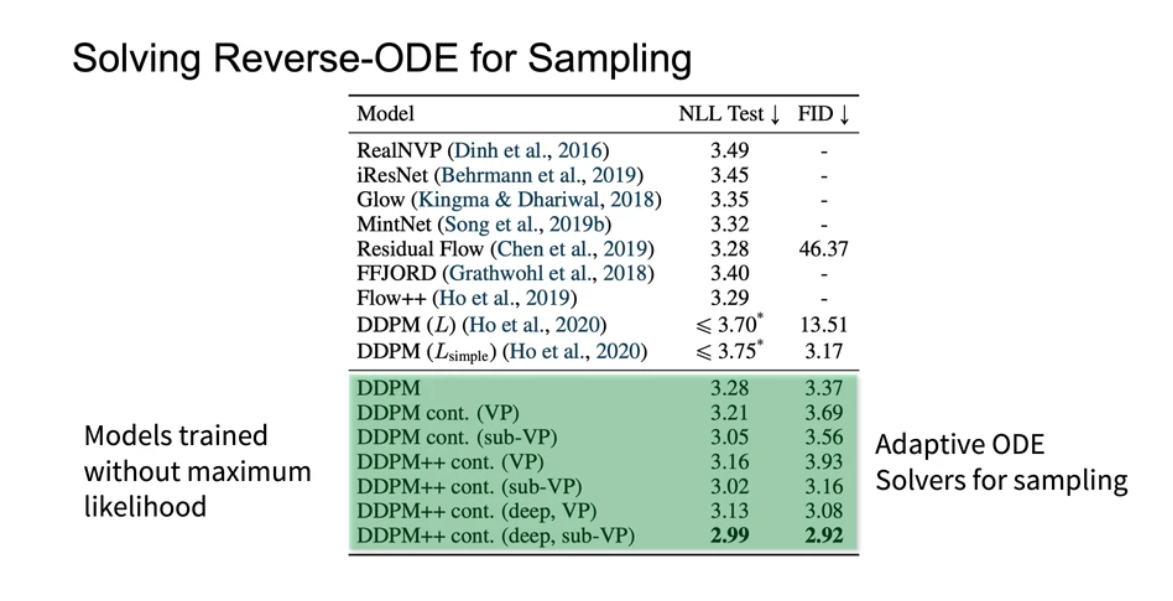

In [ ]:
Image('ode_3.png', width=1000)

La formulation du Probability flow a été utilisée pour calculer la vraisemblance d'un modèle basé sur les scores sur CIFAR-10. Les scores ont été calculés à partir d'échantillons obtenus en résolvant l'ODE de flux de probabilité avec des solveurs adaptatifs. Le Probability flow ODE a démontré une efficacité remarquable sur le dataset CIFAR-10, atteignant une vraisemblance log-négative de 2.99 bits/dim, surpassant des modèles concurrents comme RealNVP, iResNet, et Glow. Ces performances sont particulièrement notables car elles ont été obtenues sans entraînement maximisant la vraisemblance, ce qui souligne l'efficacité de la pondération de la vraisemblance et de la déquantification variationnelle utilisées dans leur approche. De plus, le modèle a aussi performé de manière compétitive sur ImageNet 32x32, avec des scores comparables aux meilleurs modèles autorégressifs, tout cela sans augmentation de données.

# Chap 4 La génération contrôlable

---

Référence:
Score-Based Generative Modeling through Stochastic Differential Equations https://papertalk.org/papertalks/29223

---

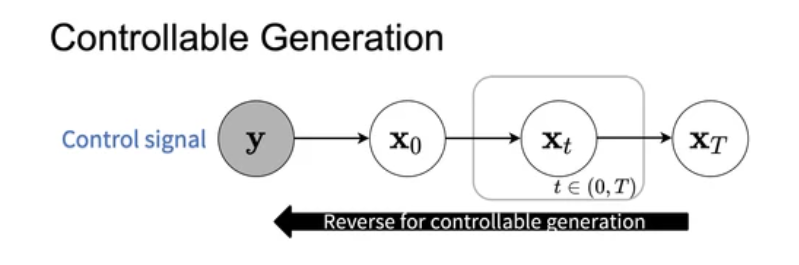

In [ ]:
Image('generation_1.png', width=600)

## 4.1 Introduction

La génération contrôlable est une des forces de l'approche basée sur les SDE. Elle permet la génération conditionnelle en entraînant un modèle de score inconditionnel unique, sans optimisation spécifique à la tâche. Pendant l'entraînement, les échantillons de données $ X_0 $ sont perturbés par un processus stochastique pour obtenir un échantillon bruité $X_T $. Pour la génération contrôlée au moment du test, un signal de contrôle $ y $ dirige le processus stochastique pour perturber conditionnellement l'échantillon $ X_0 $ donné $ y $, produisant ainsi un vecteur de bruit complet $ X_T $. En inversant cette procédure, nous pouvons partir du bruit aléatoire $ X_T $ et finalement obtenir un échantillon conditionnel $ X_0 $ étant donné $ y $. Cette méthode inverse est réalisée à travers SDE conditionnelle inverse.

SDE conditionnelle inverse s'exprime par la formule :

$$ dx = [f(x, t) -  g^2(t) \nabla_x \log p(x \mid y)] dt + g(t) dw $$

où la première partie représente le score inconditionnel, entraîné sans l'information de contrôle, et le deuxième terme, souvent entraîné séparément ou spécifié à l'aide de connaissances du domaine.

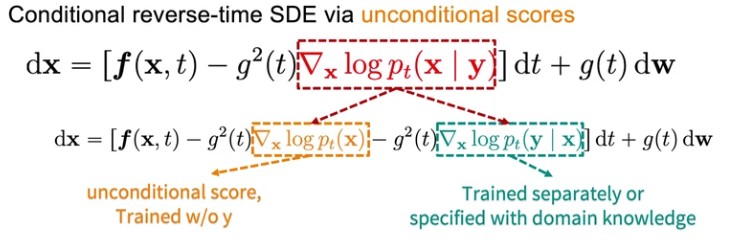

In [ ]:
Image('generation_1_2.png', width=600)

SDE conditionnelle inverse décrite est au cœur de la méthode de génération contrôlée. Le terme $ f(x, t) $ correspond à la dynamique du système indépendamment du signal de contrôle $ y $, tandis que $ - g^2(t) \nabla_x \log p(x \mid y) $ représente l'ajustement effectué pour prendre en compte la condition $ y $. Le score inconditionnel est obtenu par apprentissage du modèle sans information de contrôle, alors que le terme de conditionnement peut être inféré séparément ou déterminé via des connaissances spécifiques au domaine. La combinaison de ces composantes permet de rétro-conduire le processus de génération pour obtenir un échantillon précis correspondant au signal de contrôle donné.

## 4.2 Application

---

Référence:
Yang Song (2021). Generative Modeling by Estimating Gradients of the Data Distribution https://yang-song.net/blog/2021/score/

---


Les résultats suivants illustrent diverses applications de modèles basés sur les scores pour résoudre des problèmes inverses en vision par ordinateur. Ces applications incluent la génération conditionnelle d'images pour des classes spécifiques dans CIFAR-10, la restauration d'images et la colorisation d'images en niveaux de gris. L'étude explore également la capacité du modèle à coloriser des portraits historiques en haute résolution. Ces exemples mettent en évidence la polyvalence et l'efficacité du modèle dans diverses tâches de génération d'images contrôlée.

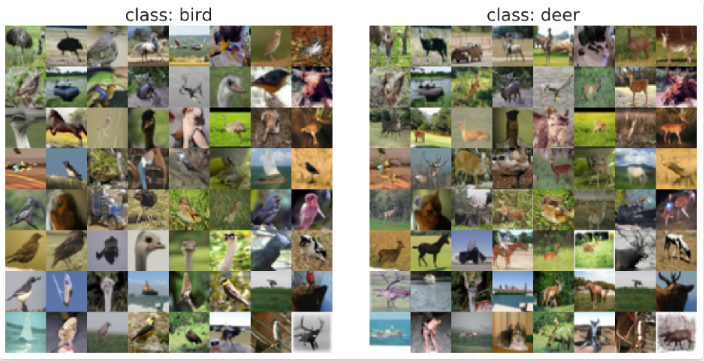

In [ ]:
Image('generation_2.png', width=800)

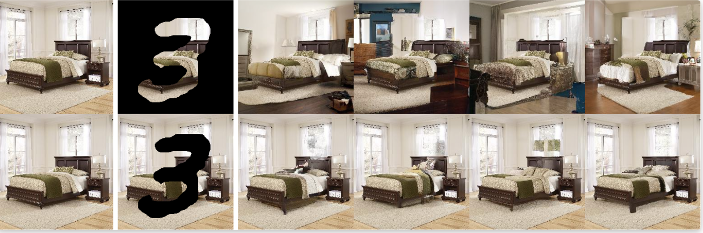

In [ ]:
Image('generation_3.png', width=800)

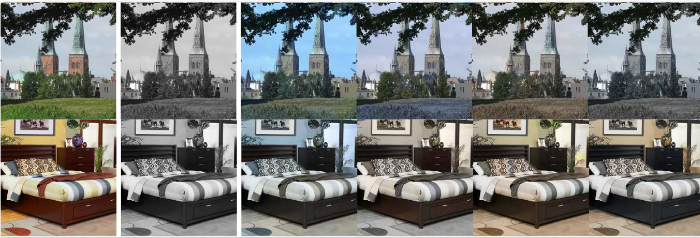

In [ ]:
Image('generation_4.png', width=800)

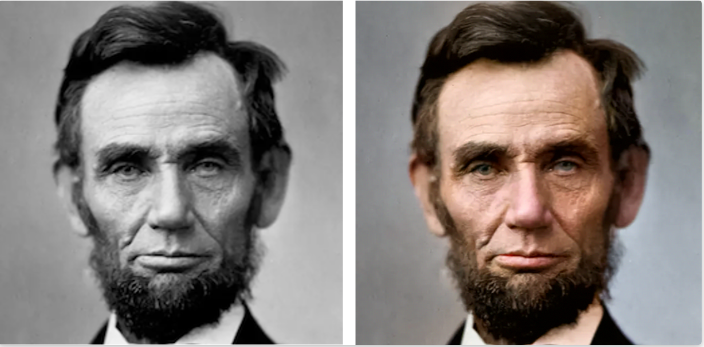

In [ ]:
Image('generation_5.png', width=800)

# Conclusion

La qualité des échantillons générés par la modélisation générative basée sur les scores et les SDE, est soit supérieure, soit au moins équivalente à celle obtenue par les GANs même si un peu moins rapide. Ce modèle s'illustre par des performances exceptionnelles sur le jeu de données CIFAR-10 et se distingue par sa capacité à générer des images de haute résolution, jusqu'à 1024x1024 pixels.

Le calcul précis de la vraisemblance est une autre réussite notable, avec des résultats compétitifs sur CIFAR-10. Le modèle permet une édition sophistiquée des échantillons en manipulant les codes latents et garantit un codage clairement identifiable, ouvrant la voie à des applications en bio-informatique et en sécurité.

Enfin, la génération contrôlable est une avancée majeure, facilitant la création d'images conditionnées à certaines classes, la retouche et la colorisation d'images, et d'autres tâches sans nécessiter un réentraînement du modèle. Cette flexibilité positionne le modèle comme une solution prometteuse pour les applications nécessitant des adaptations rapides et spécifiques.

Cependant, cette méthode présente également certaines limites. Par exemple, la formation du modèle peut être limitée par le paramétrage des équations différentielles stochastiques, ce qui fait que le modèle tombe dans une solution optimale locale. De plus, le processus d'optimisation des paramètres du modèle peut être limité. être compliqué et nécessite une optimisation des paramètres pour approfondir les options et les ajustements.Cette méthode présente certains avantages en théorie et a montré un certain potentiel dans les applications pratiques, mais des recherches et développements supplémentaires sont encore nécessaires pour remédier à ses limites.
